# Credit Analysis Project

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
#!pip install -U scikit-learn

## Imports and dataset loading

In [5]:
import pandas as pd
import numpy as np

from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score

The process we will follow to partition data is described on the chart bellow

In [6]:
df = pd.read_table('gdrive/MyDrive/TRNcod.xls')

df.dropna(inplace = True)

df.head()

,INDEX,UF_1,UF_2,UF_3,UF_4,UF_5,UF_6,UF_7,IDADE,SEXO_1,...,CEP4_7,CEP4_8,CEP4_9,CEP4_10,CEP4_11,CEP4_12,CEP4_13,CEP4_14,IND_BOM_1_1,IND_BOM_1_2
0,0,1,1,1,0,0,0,0,0.135098,1,...,0,0,1,1,0,1,1,1,0,1
1,1,1,0,1,0,0,1,0,0.273504,1,...,0,1,0,1,1,0,0,0,1,0
2,2,1,0,1,0,0,1,0,0.281910,0,...,1,1,0,0,0,0,1,0,1,0
3,3,1,1,1,0,0,0,0,0.225741,0,...,1,1,0,1,1,0,1,0,1,0
4,4,1,1,0,0,0,1,0,0.480403,0,...,1,1,1,0,0,1,0,1,1,0


In [7]:
print('Quantidade de instâncias: {}\nQuantidade de atributos: {}\n'.format(len(df), len(df.columns)))

Quantidade de instâncias: 389196
Quantidade de atributos: 246



### First Step: 
#### Splitting the Dataset on Two Classes

In [8]:
df['IND_BOM_1_2'].value_counts()

0    255098
1    134098
Name: IND_BOM_1_2, dtype: int64

In [9]:
df0 = df.loc[(df['IND_BOM_1_2']) == 0]
print('Quantidade de instâncias na classe 0 :' + str(len(df0)))

Quantidade de instâncias na classe 0 :255098


In [10]:
df1 = df.loc[(df['IND_BOM_1_2']) == 1]
print('Quantidade de instâncias na classe 1 :' + str(len(df1)))

Quantidade de instâncias na classe 1 :134098


### Second Step: 
#### Splitting on train, test and validation and augmenting to compensate data bias

In [11]:
#First we shuffle the dataset
df0 = df0.sample(frac=1, random_state=33)
#Then we split the dataset in three
len_df0 = len(df0)
train_0, validate_0, test_0 = df0[0:int(len_df0*.5)], df0[int(len_df0*.5):int(len_df0*.75)], df0[int(len_df0*.75):]

print("Size of train_0: ", len(train_0), "\nSize of validate_0: ", len(validate_0), "\nSize of test_0:", len(test_0))

Size of train_0:  127549 
Size of validate_0:  63774 
Size of test_0: 63775


In [12]:
#First we shuffle the dataset
df1 = df1.sample(frac=1, random_state=33)
#Then we split the dataset in three
len_df1 = len(df1)
train_1, validate_1, test_1 = df1[0:int(len_df1*.5)], df1[int(len_df1*.5):int(len_df1*.75)], df1[int(len_df1*.75):]

print("Size of train_1: ", len(train_1), "\nSize of validate_1: ", len(validate_1), "\nSize of test_1:", len(test_1))

Size of train_1:  67049 
Size of validate_1:  33524 
Size of test_1: 33525


#### We can see that class 1 contains less samples than class 0, thus we must perform a augmentation on out data to avoid a biased train

In [13]:
train_data_ratio = len(train_1)/len(train_0)
validate_data_ratio = len(validate_1)/len(validate_0)

#We augment our data multiplying its size by 1/ratio 
new_train_1_len = int(len(train_1)/train_data_ratio)
new_validate_1_len = int(len(validate_1)/validate_data_ratio)

#We get a random sample that has the size we need to augment our data
train_1_aug = train_1.sample(frac=1, random_state = 33)[:new_train_1_len - len(train_1)]
validate_1_aug = validate_1.sample(frac=1, random_state = 33)[:new_validate_1_len - len(validate_1)]

#Finally, we concatenate our data with the augmentation data
train_1 = pd.concat([train_1, train_1_aug])
validate_1 = pd.concat([validate_1, validate_1_aug])

print("New train_1 len: " ,len(train_1), "\nNew validate_1 len: ", len(validate_1))

New train_1 len:  127549 
New validate_1 len:  63774


### Third Step:
#### Rejoining the and shuflling datasets

In [14]:
train = pd.concat([train_0, train_1]).sample(frac=1, random_state=33)
validate = pd.concat([validate_0, validate_1]).sample(frac=1, random_state=33)
#The test set does not need to be shuflled
test = pd.concat([test_0, test_1])

# Making Models for prediction

## Separating inputs from predictions

In [41]:
import torch
from torch.utils.data import Dataset, DataLoader
class RiskAnalysisDataset(Dataset):
    
    def __init__(self, data_features, data_labels):
        self.data_features = torch.tensor(data_features.copy()).float()
        self.data_labels = torch.tensor(data_labels.copy()).float()
    
    def __len__(self):
        return len(self.data_features)
    
    def __getitem__(self, index):
        return self.data_features[index], self.data_labels[index]
        

train_x = train.iloc[:, 0:244]
train_Y = train.iloc[:, -1]
train_data = RiskAnalysisDataset(train_x.values, train_Y.values)
# variar batch train_loader = DataLoader(train_data, batch_size)

validation_x = validate.iloc[:, 0:244]
validation_Y = validate.iloc[:, -1]
validation_data = RiskAnalysisDataset(validation_x.values, validation_Y.values)

test_x = test.iloc[:, 0:244]
test_Y = test.iloc[:, -1]
test_data = RiskAnalysisDataset(test_x.values, test_Y.values)

## Metrics used for evaluation

In [16]:
!pip install scikit-plot
from sklearn.metrics import roc_curve, auc, mean_squared_error, confusion_matrix, classification_report
from scipy.stats import ks_2samp
import scikitplot as skplt
import matplotlib
import matplotlib.pyplot as plt

def ks_stat(y, yhat):
    return ks_2samp(yhat[y==1], yhat[y!=1]).statistic

def get_metrics(y, yhat, y_proba=None):
  results = dict()

  
  if (y_proba is not None):
    skplt.metrics.plot_ks_statistic(y, y_proba)
    plt.show()
  false_positive_rate, true_positive_rate, thresholds = roc_curve(y, yhat)
  results['auroc'] = auc(false_positive_rate, true_positive_rate)
  results['KS'] = ks_stat(y, yhat)
  results['MSE'] = mean_squared_error(y,yhat)
  results['confusion_matrix'] = confusion_matrix(y,yhat)
  results['classification_report'] = classification_report(y,yhat)
  for key in results:
    print(key, ' ' , str(results[key]))
  return results

#RF_model = RandomForestClassifier(max_features = 7, max_depth = 10)
#RF_model.fit(train_x, train_Y)
#y_pred = RF_model.predict(validation_x)
#y_proba = RF_model.predict_proba(validation_x)
#results = get_metrics(validation_Y, y_pred, y_proba)

## MLP

In [42]:
class MLP(torch.nn.Module):
  def __init__(self, input_size, num_neurons, num_hidden_layers, activation_func):
      super(MLP, self).__init__()
      self.input_size = input_size
      self.num_neurons  = num_neurons
      self.num_hidden_layers = num_hidden_layers
      self.activation_func = activation_func
      self.sigmoid = torch.nn.Sigmoid()
      self.fc1 = torch.nn.Linear(self.input_size, self.num_neurons)
      self.hidden_layers = []
      #hidden_layers
      for i in range(self.num_hidden_layers):
        self.hidden_layers.append(torch.nn.Linear(self.num_neurons, self.num_neurons))
      self.fc2 = torch.nn.Linear(self.num_neurons, 1)
  def forward(self, x):
      x = self.fc1(x)
      x = self.activation_func(x)
      for hidden in self.hidden_layers:
        x = hidden(x)
        x = self.activation_func(x)
      x = self.fc2(x)
      x = self.sigmoid(x)
      return x

model = MLP(244, 5, 1, torch.nn.Sigmoid())
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
criterion = torch.nn.MSELoss()

In [43]:
train_loader = DataLoader(train_data, 16)
LOSS = []
epochs = 2
for epoch in range(epochs):
  for x,y in train_loader:
    yhat = model(x)
    loss = criterion(yhat, y)
    LOSS.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step() 

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


KeyboardInterrupt: ignored

In [34]:
print(LOSS)

[0.24798375368118286, 0.2501220405101776, 0.25145673751831055, 0.2511568069458008, 0.24921450018882751, 0.2521229684352875, 0.25057482719421387, 0.25000646710395813, 0.2500060796737671, 0.25030553340911865, 0.2501392066478729, 0.24888069927692413, 0.25109878182411194, 0.25237831473350525, 0.2500005066394806, 0.2500005066394806, 0.2499132603406906, 0.25031253695487976, 0.24964480102062225, 0.2510192394256592, 0.25003236532211304, 0.25072163343429565, 0.24956324696540833, 0.25002777576446533, 0.24938622117042542, 0.2492019534111023, 0.24798670411109924, 0.25013554096221924, 0.24871404469013214, 0.2469722032546997, 0.25424036383628845, 0.25313037633895874, 0.2520814836025238, 0.24948224425315857, 0.24929261207580566, 0.2500569820404053, 0.25097036361694336, 0.24802206456661224, 0.25142571330070496, 0.247959166765213, 0.24719925224781036, 0.24835313856601715, 0.2461877018213272, 0.2503760755062103, 0.2527105212211609, 0.2544086277484894, 0.24859081208705902, 0.2501944899559021, 0.253571361

## Random Forest

### First set of experiments
Here we preliminarly found min_sample_splits and max_dephts best parameters and experimented with max_samples and max_features to try improving our model.

In [ ]:
# Set of hyper-parameters for grid search

max_samples = [None, 0.75, 0.6]
# Sqrt of columns_number
max_features =  [244, 200, 150,120,90,70]
max_depths = [10]
min_samples_splits = [0.0015]
RF_test_results = []

Max_sample None Max_feature 244 Max_depht 10 Min_samples_split 0.0015


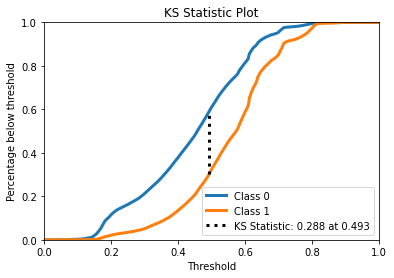

auroc   0.6431332655732089
KS   0.28626653114641776
MSE   0.3673175745118191
confusion_matrix   [[38872 24903]
 [10837 22688]]
classification_report                 precision    recall  f1-score   support

           0       0.78      0.61      0.69     63775
           1       0.48      0.68      0.56     33525

    accuracy                           0.63     97300
   macro avg       0.63      0.64      0.62     97300
weighted avg       0.68      0.63      0.64     97300

Max_sample None Max_feature 200 Max_depht 10 Min_samples_split 0.0015


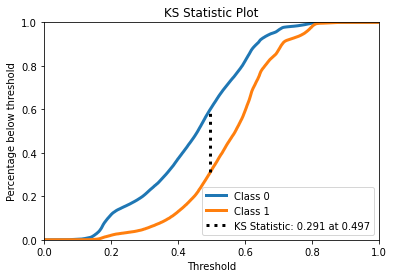

auroc   0.6448336705261875
KS   0.28966734105237496
MSE   0.36623843782117166
confusion_matrix   [[38853 24922]
 [10713 22812]]
classification_report                 precision    recall  f1-score   support

           0       0.78      0.61      0.69     63775
           1       0.48      0.68      0.56     33525

    accuracy                           0.63     97300
   macro avg       0.63      0.64      0.62     97300
weighted avg       0.68      0.63      0.64     97300

Max_sample None Max_feature 150 Max_depht 10 Min_samples_split 0.0015


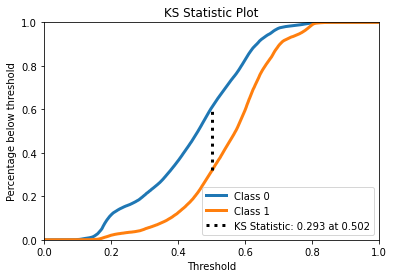

auroc   0.6460257810026686
KS   0.29205156200533716
MSE   0.3660945529290853
confusion_matrix   [[38714 25061]
 [10560 22965]]
classification_report                 precision    recall  f1-score   support

           0       0.79      0.61      0.68     63775
           1       0.48      0.69      0.56     33525

    accuracy                           0.63     97300
   macro avg       0.63      0.65      0.62     97300
weighted avg       0.68      0.63      0.64     97300

Max_sample None Max_feature 120 Max_depht 10 Min_samples_split 0.0015


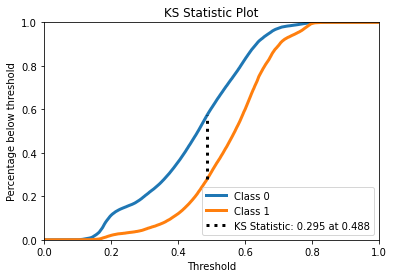

auroc   0.6467244118564432
KS   0.29344882371288644
MSE   0.36602261048304213
confusion_matrix   [[38630 25145]
 [10469 23056]]
classification_report                 precision    recall  f1-score   support

           0       0.79      0.61      0.68     63775
           1       0.48      0.69      0.56     33525

    accuracy                           0.63     97300
   macro avg       0.63      0.65      0.62     97300
weighted avg       0.68      0.63      0.64     97300

Max_sample None Max_feature 90 Max_depht 10 Min_samples_split 0.0015


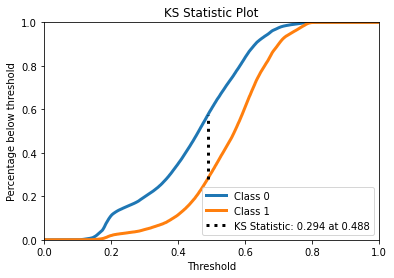

auroc   0.6465403603914887
KS   0.29308072078297726
MSE   0.3671634121274409
confusion_matrix   [[38422 25353]
 [10372 23153]]
classification_report                 precision    recall  f1-score   support

           0       0.79      0.60      0.68     63775
           1       0.48      0.69      0.56     33525

    accuracy                           0.63     97300
   macro avg       0.63      0.65      0.62     97300
weighted avg       0.68      0.63      0.64     97300

Max_sample None Max_feature 70 Max_depht 10 Min_samples_split 0.0015


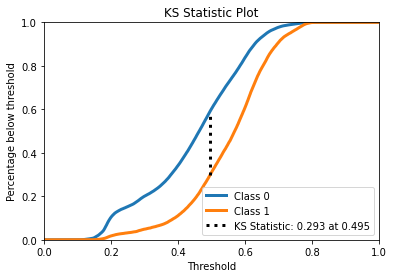

auroc   0.6462533416001854
KS   0.2925066832003709
MSE   0.36750256937307296
confusion_matrix   [[38393 25382]
 [10376 23149]]
classification_report                 precision    recall  f1-score   support

           0       0.79      0.60      0.68     63775
           1       0.48      0.69      0.56     33525

    accuracy                           0.63     97300
   macro avg       0.63      0.65      0.62     97300
weighted avg       0.68      0.63      0.64     97300

Max_sample 0.75 Max_feature 244 Max_depht 10 Min_samples_split 0.0015


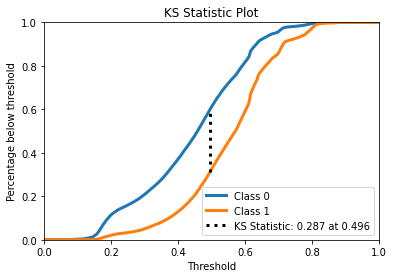

auroc   0.6430900955335905
KS   0.28618019106718107
MSE   0.3669475847893114
confusion_matrix   [[38954 24821]
 [10883 22642]]
classification_report                 precision    recall  f1-score   support

           0       0.78      0.61      0.69     63775
           1       0.48      0.68      0.56     33525

    accuracy                           0.63     97300
   macro avg       0.63      0.64      0.62     97300
weighted avg       0.68      0.63      0.64     97300

Max_sample 0.75 Max_feature 200 Max_depht 10 Min_samples_split 0.0015


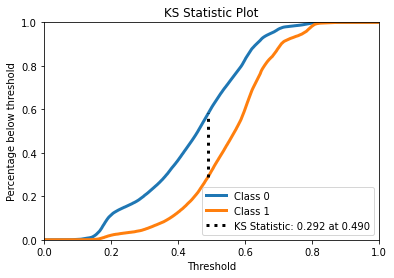

auroc   0.6453341834042652
KS   0.29066836680853037
MSE   0.3665467625899281
confusion_matrix   [[38719 25056]
 [10609 22916]]
classification_report                 precision    recall  f1-score   support

           0       0.78      0.61      0.68     63775
           1       0.48      0.68      0.56     33525

    accuracy                           0.63     97300
   macro avg       0.63      0.65      0.62     97300
weighted avg       0.68      0.63      0.64     97300

Max_sample 0.75 Max_feature 150 Max_depht 10 Min_samples_split 0.0015


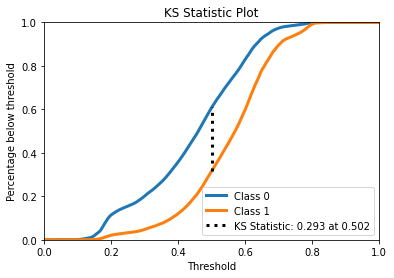

auroc   0.6462674724216586
KS   0.29253494484331716
MSE   0.3658890030832477
confusion_matrix   [[38722 25053]
 [10548 22977]]
classification_report                 precision    recall  f1-score   support

           0       0.79      0.61      0.69     63775
           1       0.48      0.69      0.56     33525

    accuracy                           0.63     97300
   macro avg       0.63      0.65      0.62     97300
weighted avg       0.68      0.63      0.64     97300

Max_sample 0.75 Max_feature 120 Max_depht 10 Min_samples_split 0.0015


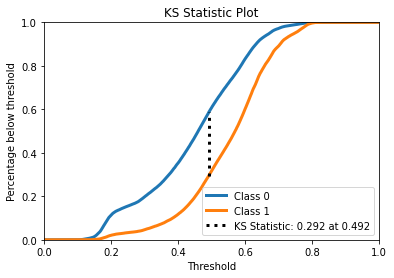

auroc   0.6454074040944303
KS   0.29081480818886074
MSE   0.36660842754367934
confusion_matrix   [[38696 25079]
 [10592 22933]]
classification_report                 precision    recall  f1-score   support

           0       0.79      0.61      0.68     63775
           1       0.48      0.68      0.56     33525

    accuracy                           0.63     97300
   macro avg       0.63      0.65      0.62     97300
weighted avg       0.68      0.63      0.64     97300

Max_sample 0.75 Max_feature 90 Max_depht 10 Min_samples_split 0.0015


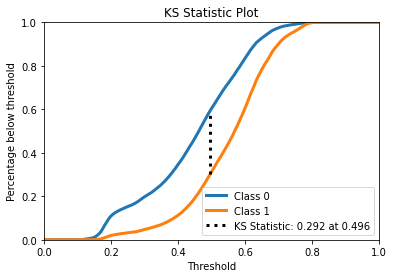

auroc   0.6459407680630573
KS   0.2918815361261145
MSE   0.36723535457348405
confusion_matrix   [[38492 25283]
 [10449 23076]]
classification_report                 precision    recall  f1-score   support

           0       0.79      0.60      0.68     63775
           1       0.48      0.69      0.56     33525

    accuracy                           0.63     97300
   macro avg       0.63      0.65      0.62     97300
weighted avg       0.68      0.63      0.64     97300

Max_sample 0.75 Max_feature 70 Max_depht 10 Min_samples_split 0.0015


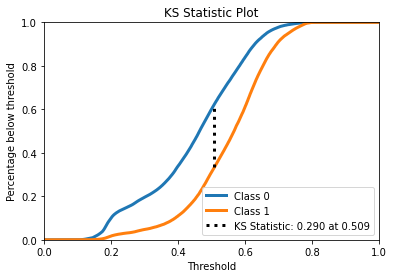

auroc   0.6448783080197528
KS   0.28975661603950553
MSE   0.36896197327852004
confusion_matrix   [[38288 25487]
 [10413 23112]]
classification_report                 precision    recall  f1-score   support

           0       0.79      0.60      0.68     63775
           1       0.48      0.69      0.56     33525

    accuracy                           0.63     97300
   macro avg       0.63      0.64      0.62     97300
weighted avg       0.68      0.63      0.64     97300

Max_sample 0.6 Max_feature 244 Max_depht 10 Min_samples_split 0.0015


KeyboardInterrupt: ignored

In [ ]:
#Experiments via grid_search
for max_sample in max_samples:
  for max_feature in max_features:
    for max_depth in max_depths:
      for min_samples_split in min_samples_splits:
        print("Max_sample " + str(max_sample) + " Max_feature " + str(max_feature) + " Max_depht " + str(max_depth) +" Min_samples_split " + str(min_samples_split))
        RF_model = RandomForestClassifier(max_depth = max_depth, max_samples = max_sample, max_features = max_feature, min_samples_split = min_samples_split)
        RF_model.fit(train_x, train_Y)
        yhat = RF_model.predict(test_x)
        y_proba = RF_model.predict_proba(test_x)
        result = get_metrics(test_Y, yhat, y_proba)
        RF_test_results.append(({"max_sample" : max_sample,"max_feature":max_feature}, result))

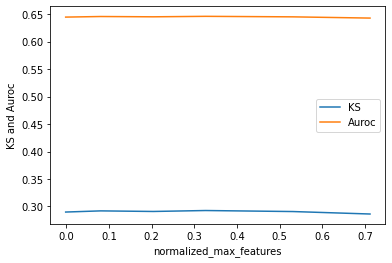

In [ ]:
results_ks = []
results_auroc = []
for dic, result in RF_test_results:
  if (dic['max_sample'] == 0.75):
    results_ks.append(result['KS'])
    results_auroc.append(result['auroc'])
  
normalized_max_features = []
for i in max_features:
  normalized_max_features.append((i-70/244-70)/244)

plt.plot(normalized_max_features, results_ks, label = "KS")
plt.plot(normalized_max_features, results_auroc, label = "Auroc")
plt.xlabel('normalized_max_features') 
plt.ylabel('KS and Auroc') 
plt.legend()
plt.show()

### Second set of experiments
After finding the best hyper_parameters on the above experiments we proceeded looking at the effect of changes on the number of estimators.

In [ ]:
# Set of hyper-parameters for grid search

n_estimators = [100, 110, 120, 130]
#Found the bellow parameters after severale experiments
max_samples = [0.75]
max_features =  [130]
max_depths = [10]
min_samples_splits = [0.0015]
RF_test_results = []

N_estimators 100 Max_sample 0.75 Max_feature 130 Max_depht 10 Min_samples_split 0.0015


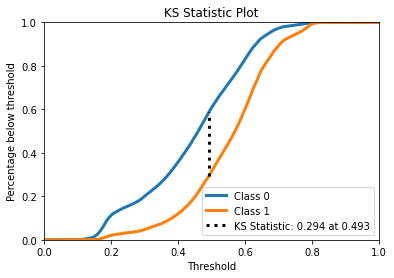

auroc   0.6462865785551192
KS   0.29257315711023824
MSE   0.36601233299075026
confusion_matrix   [[38694 25081]
 [10532 22993]]
classification_report                 precision    recall  f1-score   support

           0       0.79      0.61      0.68     63775
           1       0.48      0.69      0.56     33525

    accuracy                           0.63     97300
   macro avg       0.63      0.65      0.62     97300
weighted avg       0.68      0.63      0.64     97300

N_estimators 110 Max_sample 0.75 Max_feature 130 Max_depht 10 Min_samples_split 0.0015


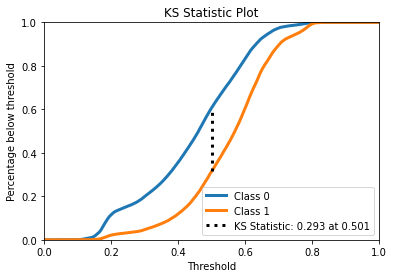

auroc   0.6461701059753147
KS   0.2923402119506292
MSE   0.3663412127440904
confusion_matrix   [[38643 25132]
 [10513 23012]]
classification_report                 precision    recall  f1-score   support

           0       0.79      0.61      0.68     63775
           1       0.48      0.69      0.56     33525

    accuracy                           0.63     97300
   macro avg       0.63      0.65      0.62     97300
weighted avg       0.68      0.63      0.64     97300

N_estimators 120 Max_sample 0.75 Max_feature 130 Max_depht 10 Min_samples_split 0.0015


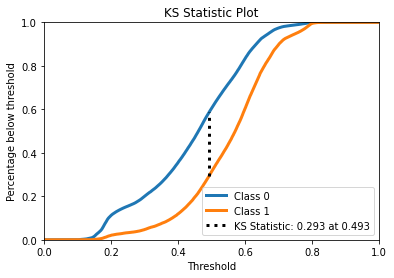

auroc   0.6458319952316516
KS   0.29166399046330327
MSE   0.36708119218910584
confusion_matrix   [[38539 25236]
 [10481 23044]]
classification_report                 precision    recall  f1-score   support

           0       0.79      0.60      0.68     63775
           1       0.48      0.69      0.56     33525

    accuracy                           0.63     97300
   macro avg       0.63      0.65      0.62     97300
weighted avg       0.68      0.63      0.64     97300

N_estimators 130 Max_sample 0.75 Max_feature 130 Max_depht 10 Min_samples_split 0.0015


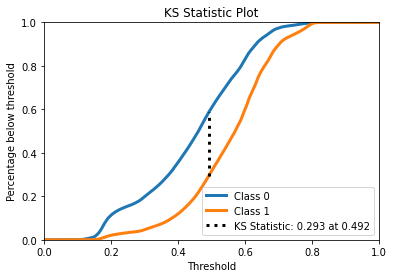

auroc   0.6456337778666436
KS   0.29126755573328705
MSE   0.36660842754367934
confusion_matrix   [[38664 25111]
 [10560 22965]]
classification_report                 precision    recall  f1-score   support

           0       0.79      0.61      0.68     63775
           1       0.48      0.69      0.56     33525

    accuracy                           0.63     97300
   macro avg       0.63      0.65      0.62     97300
weighted avg       0.68      0.63      0.64     97300



In [ ]:
#Experiments via grid_search
for n_estimator in n_estimators:
  for max_sample in max_samples:
    for max_feature in max_features:
      for max_depth in max_depths:
        for min_samples_split in min_samples_splits:
          print("N_estimators " + str(n_estimator) + " Max_sample " + str(max_sample) + " Max_feature " + str(max_feature) + " Max_depht " + str(max_depth) +" Min_samples_split " + str(min_samples_split))
          RF_model = RandomForestClassifier(max_depth = max_depth, max_samples = max_sample, max_features = max_feature, min_samples_split = min_samples_split)
          RF_model.fit(train_x, train_Y)
          yhat = RF_model.predict(test_x)
          y_proba = RF_model.predict_proba(test_x)
          result = get_metrics(test_Y, yhat, y_proba)
          RF_test_results.append((n_estimator, result))

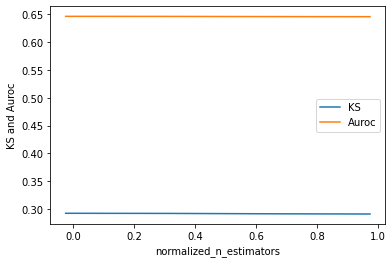

In [ ]:
results_ks = []
results_auroc = []
for _, result in RF_test_results:
  results_ks.append(result['KS'])
  results_auroc.append(result['auroc'])

normalized_n_estimators = []
for i in n_estimators:
  normalized_n_estimators.append((i-100/130-100)/30)

plt.plot(normalized_n_estimators, results_ks, label = "KS")
plt.plot(normalized_n_estimators, results_auroc, label = "Auroc")
plt.xlabel('normalized_n_estimators') 
plt.ylabel('KS and Auroc') 
plt.legend()
plt.show()


In [ ]:
import os
if not (os.path.isdir("/teste/oi/a")):
  os.makedirs("/teste/oi/a")

results/flower/DEMO/DEMO


In [2]:
a = "sdsdj %s asds"
a.format("ulu")

'sdsdj %s asds'